In [1]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import numpy as np
# import matplotlib
# matplotlib.use("Agg")
import matplotlib.pyplot as plt
from astropy.table import Table, vstack, hstack, join
import fitsio
# from astropy.io import fits

In [2]:
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'figure.facecolor':'w'} 
plt.rcParams.update(params)

In [3]:
def get_clean_lrgs(cat):

    # Remove FIBERSTATUS!=0 fibers
    mask = cat['COADD_FIBERSTATUS']==0
    print('FIBERSTATUS',np.sum(mask), np.sum(~mask), np.sum(~mask)/len(mask))

    # Remove "no data" fibers
    mask &= cat['ZWARN'] & 2**9==0
    print('No data', np.sum(mask), np.sum(~mask), np.sum(~mask)/len(mask))

    # Apply LRG mask
    mask &= cat['lrg_mask']==0
    print('LRG mask', np.sum(mask), np.sum(~mask), np.sum(~mask)/len(mask))

    # # Remove QSO targets
    # mask &= cat['DESI_TARGET'] & 2**2 ==0
    # print('Remove QSO targets', np.sum(mask), np.sum(~mask), np.sum(~mask)/len(mask))

    # Julien's bad fibers list + my list of worst-performing fibers; failures_analysis-everest.ipynb
    bad_fibers = np.loadtxt('/global/cfs/cdirs/desi/users/rongpu/spectro/everest/misc/bad_fibers_20211013.txt', dtype=int)
    # bad_fibers = np.loadtxt('/Users/rongpu/Documents/Data/desi_data/everest/misc/bad_fibers_20211013.txt', dtype=int)
    print(len(bad_fibers))
    mask_bad = np.in1d(cat['FIBER'], bad_fibers)
    print('Bad fibers', np.sum(~mask_bad), np.sum(mask_bad), np.sum(mask_bad)/len(mask_bad))
    mask &= (~mask_bad)
    
    print(np.sum(mask), np.sum(mask)/len(mask))

    return mask


def get_redshift_quality(cat):
    
    # Custom DELTACHI2 vs z cut
    d = (10**(3 - 3.5*cat['Z']))
    mask_remove = (d>30) & (cat['DELTACHI2']<30)
    mask_remove |= (d<30) & (cat['DELTACHI2']<d)
    mask_remove |= (cat['DELTACHI2']<10)
    mask_quality = cat['ZWARN']==0
    mask_quality &= cat['Z']<1.4
    mask_quality &= (~mask_remove)
    
    print(1-np.sum(mask_quality)/len(mask_quality))

    return mask_quality

In [4]:
cat = Table(fitsio.read('/global/cfs/cdirs/desi/users/rongpu/spectro/everest/sv1_low_speed_lrg.fits'))

cat['tile_petal'] = np.array(cat['TILEID']*10 + cat['PETAL_LOC'])

cat['EFFTIME_ELG'] = 8.60 * cat['TSNR2_ELG']
cat['EFFTIME_LRG'] = 12.15 * cat['TSNR2_LRG']

mask = get_clean_lrgs(cat)
print(np.sum(mask), np.sum(mask)/len(mask))
cat = cat[mask]
print(len(cat), len(np.unique(cat['TARGETID'])))

cat['good_z'] = get_redshift_quality(cat)

FIBERSTATUS 5017 896 0.1515305259597497
No data 5017 896 0.1515305259597497
LRG mask 4786 1127 0.19059698968374766
333
Bad fibers 5529 384 0.06494165398274987
4476 0.7569761542364282
4476 0.7569761542364282
4476 3048
0.1150580875781948


In [5]:
print(len(cat))
cat['zfibermag'] = 22.5 - 2.5*np.log10(cat['FIBERFLUX_Z']) - 1.211 * cat['EBV']
mask = (cat['zfibermag']<21.8) & (cat['zfibermag']>21.)
cat = cat[mask]
print(len(cat))

# mask = cat['main_lrg']==True
# cat = cat[mask]

# mask = cat['TILEID']==80605
# cat = cat[mask]

4476
1896


In [6]:
# Deep and 1x nominal coadds

deep = Table(fitsio.read('/global/cfs/cdirs/desi/users/rongpu/spectro/everest/sv1_cumulative_lrg.fits'))
nominal = Table(fitsio.read('/global/cfs/cdirs/desi/users/rongpu/spectro/everest/sv1_1x_depth_lrg.fits'))

deep['tile_petal'] = np.array(deep['TILEID']*10 + deep['PETAL_LOC'])
nominal['tile_petal'] = np.array(nominal['TILEID']*10 + nominal['PETAL_LOC'])

deep['EFFTIME_LRG'] = 12.15 * deep['TSNR2_LRG']
nominal['EFFTIME_LRG'] = 12.15 * nominal['TSNR2_LRG']

mask = np.in1d(deep['tile_petal'], cat['tile_petal'])
mask &= np.in1d(deep['TARGETID'], cat['TARGETID'])
mask &= get_clean_lrgs(deep)
deep = deep[mask]
print(len(deep))
print()

mask = np.in1d(nominal['tile_petal'], cat['tile_petal'])
mask &= np.in1d(nominal['TARGETID'], cat['TARGETID'])
mask &= get_clean_lrgs(nominal)
nominal = nominal[mask]
print(len(nominal))
print()

deep['good_z'] = get_redshift_quality(deep)
nominal['good_z'] = get_redshift_quality(nominal)

deep['zfibermag'] = 22.5 - 2.5*np.log10(deep['FIBERFLUX_Z']) - 1.211 * deep['EBV']

FIBERSTATUS 46403 8832 0.15989861500859961
No data 46401 8834 0.15993482393409975
LRG mask 42199 13036 0.23600977640988505
333
Bad fibers 51607 3628 0.06568299085724631
39295 0.7114148637639178
1297

FIBERSTATUS 27179 4874 0.15206064954918416
No data 27179 4874 0.15206064954918416
LRG mask 25072 6981 0.21779552615979783
333
Bad fibers 30058 1995 0.06224066390041494
23470 0.7322247527532524
7163

0.013878180416345365
0.06854669831076365


In [7]:
print(len(np.unique(cat['TARGETID']))==len(np.unique(deep['TARGETID'])))
print(len(np.unique(cat['TARGETID']))==len(np.unique(nominal['TARGETID'])))

True
True


In [8]:
print(len(np.unique(cat['TARGETID'][~cat['good_z']])))
print(len(np.unique(nominal['TARGETID'][~nominal['good_z']])))
print(len(np.unique(deep['TARGETID'][~deep['good_z']])))

192
252
18


In [9]:
deep1 = deep[['TARGETID', 'Z', 'good_z']].copy()
deep1.rename_columns(['Z', 'good_z'], ['Z_deep', 'good_z_deep'])

print(len(cat))
cat = join(cat, deep1, keys='TARGETID')
print(len(cat))

print(len(nominal))
nominal = join(nominal, deep1, keys='TARGETID')
print(len(nominal))

1896
1896
7163
7163


In [10]:
zdiff_threshold = 0.0033
cat['fail'] = (~cat['good_z_deep']) | (np.abs((cat['Z'] - cat['Z_deep'])/(1 + cat['Z_deep'])) > zdiff_threshold)
nominal['fail'] = (~nominal['good_z_deep']) | (np.abs((nominal['Z'] - nominal['Z_deep'])/(1 + nominal['Z_deep'])) > zdiff_threshold)

print(np.sum(cat['fail'])/len(cat))
print(np.sum(nominal['fail'])/len(nominal))

0.11023206751054852
0.06030992600865559


In [11]:
cat['speed'] = cat['EFFTIME_LRG']*10**(2*2.165*cat['EBV']/2.5)/cat['COADD_EXPTIME']
nominal['speed'] = nominal['EFFTIME_LRG']*10**(2*2.165*nominal['EBV']/2.5)/nominal['COADD_EXPTIME']
deep['speed'] = deep['EFFTIME_LRG']*10**(2*2.165*deep['EBV']/2.5)/deep['COADD_EXPTIME']

print(np.median(cat['speed']))
print(np.median(nominal['speed']))
print(np.median(deep['speed']))

0.29496795
0.61256784
0.545587


---------

213
209
79


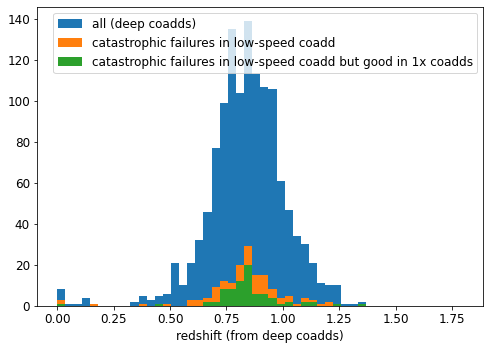

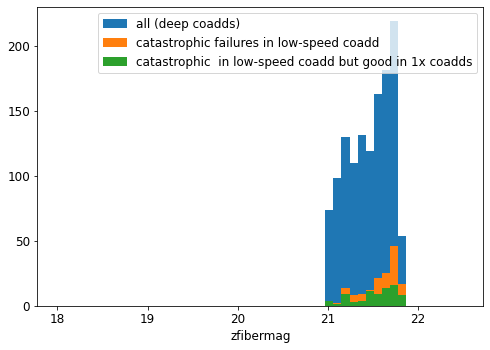

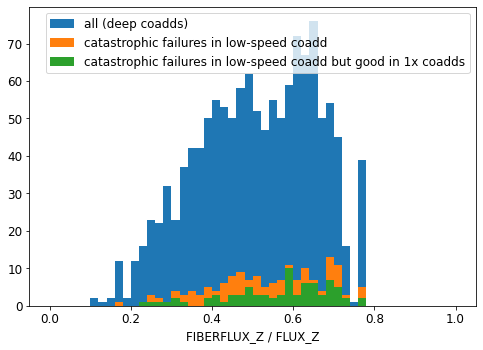

In [12]:
mask = deep['good_z'] & np.in1d(deep['TARGETID'], cat['TARGETID'][cat['fail']])

nom_fail = Table()
nom_fail['TARGETID'], nom_fail['count'] = np.unique(nominal['TARGETID'][nominal['fail']], return_counts=True)
print(len(nom_fail))
print(np.sum(cat['fail']))
bad_targetid = np.setdiff1d(cat['TARGETID'][cat['fail']], nom_fail['TARGETID'])
print(len(bad_targetid))
mask1 = deep['good_z'] & np.in1d(deep['TARGETID'], bad_targetid)

plt.figure(figsize=(8, 5.5))
plt.hist(deep['Z'][deep['good_z']], 50, range=(0, 1.8), label='all (deep coadds)')
plt.hist(deep['Z'][mask], 50, range=(0, 1.8), label='catastrophic failures in low-speed coadd')
plt.hist(deep['Z'][mask1], 50, range=(0, 1.8), label='catastrophic failures in low-speed coadd but good in 1x coadds')
plt.xlabel('redshift (from deep coadds)')
plt.legend()
plt.show()

plt.figure(figsize=(8, 5.5))
plt.hist(deep['zfibermag'][deep['good_z']], 50, range=(18, 22.5), label='all (deep coadds)')
plt.hist(deep['zfibermag'][mask], 50, range=(18, 22.5), label='catastrophic failures in low-speed coadd')
plt.hist(deep['zfibermag'][mask1], 50, range=(18, 22.5), label='catastrophic  in low-speed coadd but good in 1x coadds')
plt.xlabel('zfibermag')
plt.legend()
plt.show()

plt.figure(figsize=(8, 5.5))
plt.hist((deep['FIBERFLUX_Z']/deep['FLUX_Z'])[deep['good_z']], 50, range=(0, 1), label='all (deep coadds)')
plt.hist((deep['FIBERFLUX_Z']/deep['FLUX_Z'])[mask], 50, range=(0, 1), label='catastrophic failures in low-speed coadd')
plt.hist((deep['FIBERFLUX_Z']/deep['FLUX_Z'])[mask1], 50, range=(0, 1), label='catastrophic failures in low-speed coadd but good in 1x coadds')
plt.xlabel('FIBERFLUX_Z / FLUX_Z')
plt.legend()
plt.show()

-----

In [13]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cat['gmag'] = 22.5 - 2.5*np.log10(cat['FLUX_G']) - 3.214 * cat['EBV']
    cat['rmag'] = 22.5 - 2.5*np.log10(cat['FLUX_R']) - 2.165 * cat['EBV']
    cat['zmag'] = 22.5 - 2.5*np.log10(cat['FLUX_Z']) - 1.211 * cat['EBV']
    cat['w1mag'] = 22.5 - 2.5*np.log10(cat['FLUX_W1']) - 0.184 * cat['EBV']
    cat['w2mag'] = 22.5 - 2.5*np.log10(cat['FLUX_W2']) - 0.113 * cat['EBV']
    cat['zfibermag'] = 22.5 - 2.5*np.log10(cat['FIBERFLUX_Z']) - 1.211 * cat['EBV']

In [14]:
mask = cat['zfibermag']>21.0
mask &= cat['Z_deep']<1.4
cat = cat[mask]
print(len(cat))

mask = np.in1d(deep['tile_petal'], cat['tile_petal'])
mask &= np.in1d(deep['TARGETID'], cat['TARGETID'])
deep = deep[mask]
print(len(deep))
mask = np.in1d(nominal['tile_petal'], cat['tile_petal'])
mask &= np.in1d(nominal['TARGETID'], cat['TARGETID'])
nominal = nominal[mask]
print(len(nominal))

print(len(np.unique(cat['TARGETID']))==len(np.unique(deep['TARGETID'])))
print(len(np.unique(cat['TARGETID']))==len(np.unique(nominal['TARGETID'])))

1873
1282
7082
True
True


In [16]:
sys.path.append(os.path.expanduser('~/git/Python/useful'))
from desi_plot_spectrum import plot_spectrum

In [18]:
plot_spectrum??

39627706836454231 2
/global/cfs/cdirs/desi/spectro/redux/everest/tiles/cumulative/80605/20210205/coadd-6-80605-thru20210205.fits
INFO:spectra.py:282:read_spectra: iotime 0.503 sec to read coadd-6-80605-thru20210205.fits at 2021-11-11T09:52:57.255336
DEBUG: Read templates from /global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/code/redrock-templates/master
DEBUG: Using default redshift range -0.0050-1.6997 for rrtemplate-galaxy.fits
DEBUG: Using default redshift range 0.0500-5.9934 for rrtemplate-qso.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-A.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-B.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-CV.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-F.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-G.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-K.fits
DEBUG: U

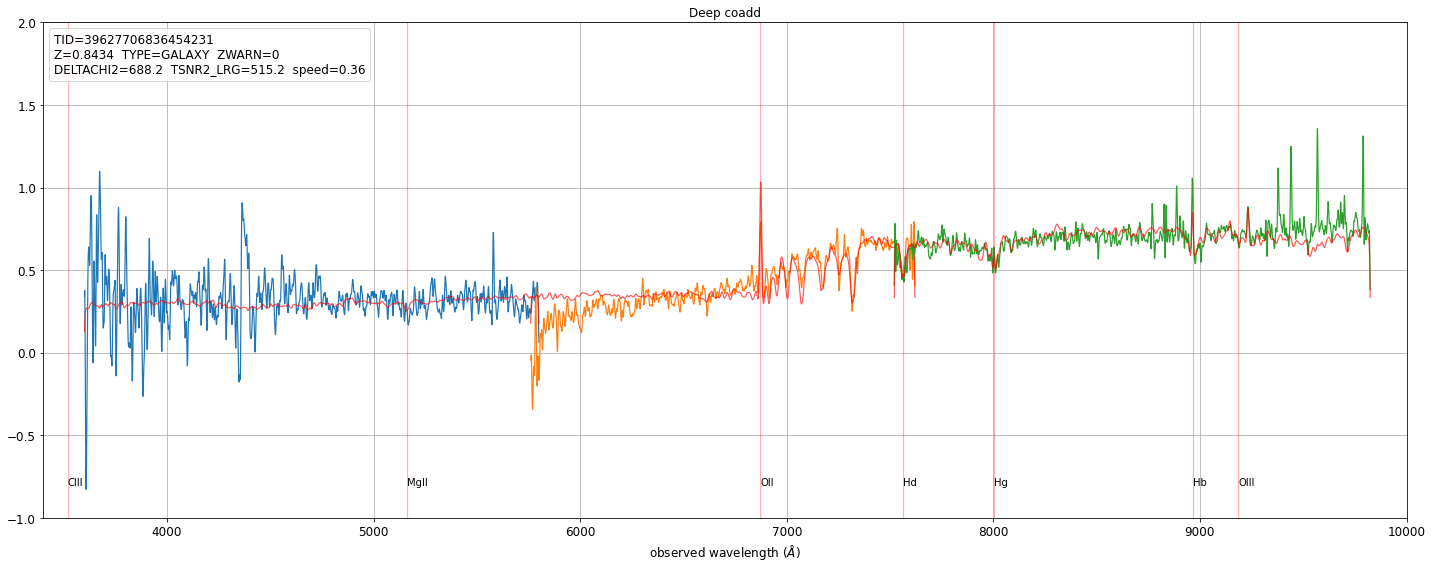


/global/cfs/cdirs/desi/spectro/redux/everest/tiles/1x_depth/80605/2/coadd-6-80605-1xsubset2.fits
INFO:spectra.py:282:read_spectra: iotime 0.460 sec to read coadd-6-80605-1xsubset2.fits at 2021-11-11T09:52:58.866815
DEBUG: Read templates from /global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/code/redrock-templates/master
DEBUG: Using default redshift range -0.0050-1.6997 for rrtemplate-galaxy.fits
DEBUG: Using default redshift range 0.0500-5.9934 for rrtemplate-qso.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-A.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-B.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-CV.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-F.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-G.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-K.fits
DEBUG: Using default redshift range -0.002

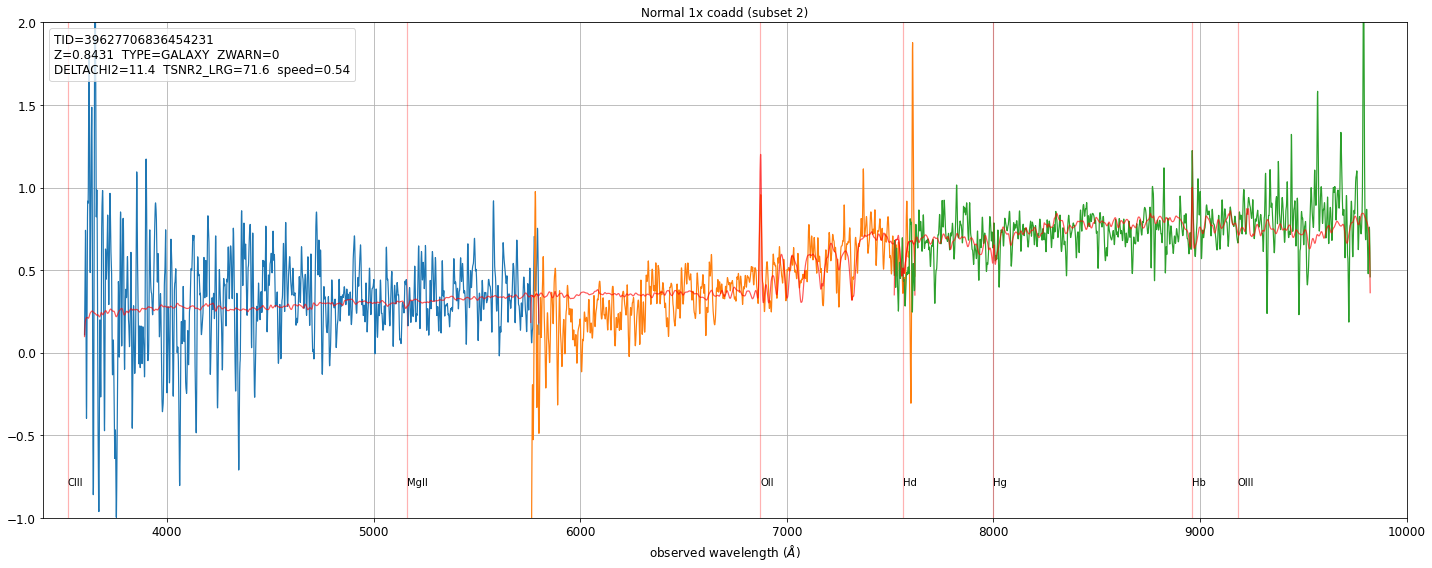


/global/cfs/cdirs/desi/spectro/redux/everest/tiles/1x_depth/80605/3/coadd-6-80605-1xsubset3.fits
INFO:spectra.py:282:read_spectra: iotime 0.475 sec to read coadd-6-80605-1xsubset3.fits at 2021-11-11T09:53:00.305719
DEBUG: Read templates from /global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/code/redrock-templates/master
DEBUG: Using default redshift range -0.0050-1.6997 for rrtemplate-galaxy.fits
DEBUG: Using default redshift range 0.0500-5.9934 for rrtemplate-qso.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-A.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-B.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-CV.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-F.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-G.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-K.fits
DEBUG: Using default redshift range -0.002

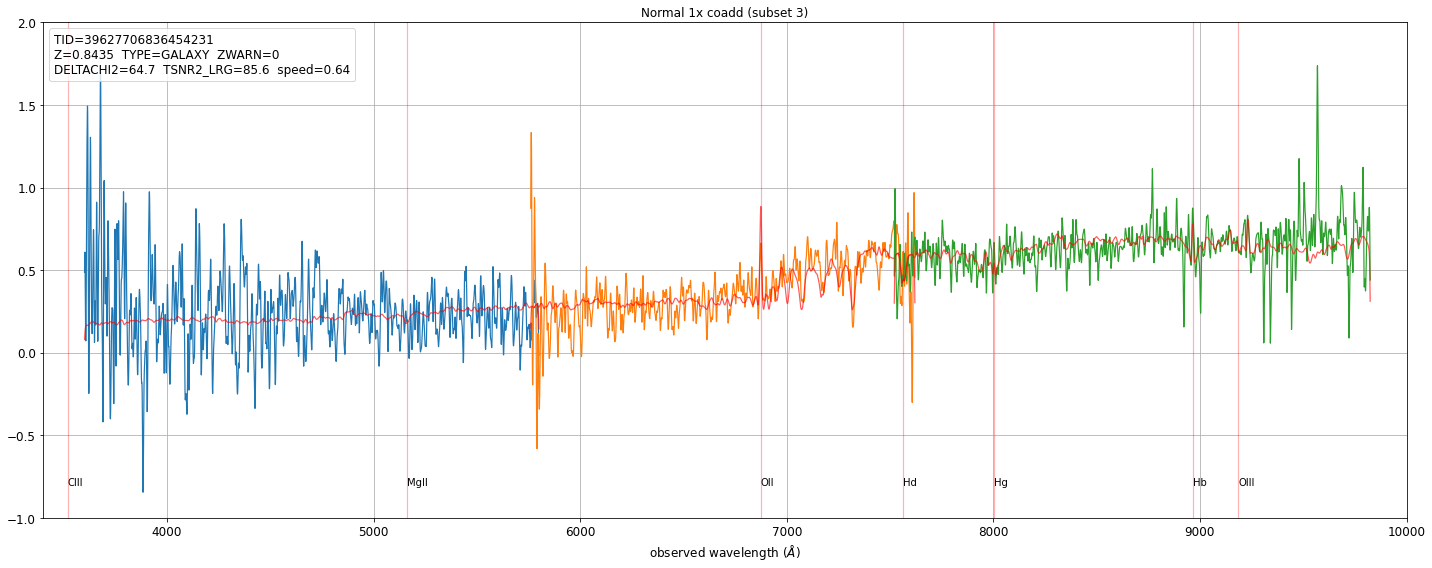


/global/cfs/cdirs/desi/users/rongpu/everest/low_speed/80605/1/coadd-6-80605-lowspeedsubset1.fits
INFO:spectra.py:282:read_spectra: iotime 0.458 sec to read coadd-6-80605-lowspeedsubset1.fits at 2021-11-11T09:53:01.721965
DEBUG: Read templates from /global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/code/redrock-templates/master
DEBUG: Using default redshift range -0.0050-1.6997 for rrtemplate-galaxy.fits
DEBUG: Using default redshift range 0.0500-5.9934 for rrtemplate-qso.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-A.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-B.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-CV.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-F.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-G.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-K.fits
DEBUG: Using default redshift range 

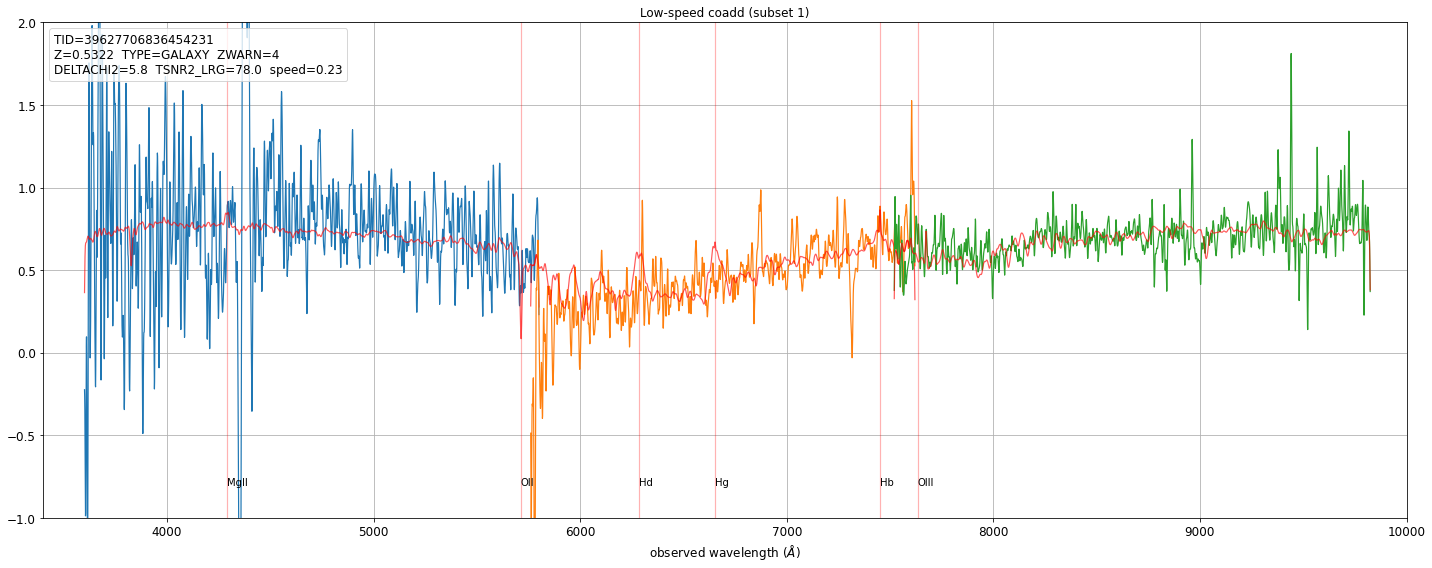


39627706836454231 1
/global/cfs/cdirs/desi/spectro/redux/everest/tiles/cumulative/80605/20210205/coadd-6-80605-thru20210205.fits
INFO:spectra.py:282:read_spectra: iotime 0.467 sec to read coadd-6-80605-thru20210205.fits at 2021-11-11T09:53:03.100754
DEBUG: Read templates from /global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/code/redrock-templates/master
DEBUG: Using default redshift range -0.0050-1.6997 for rrtemplate-galaxy.fits
DEBUG: Using default redshift range 0.0500-5.9934 for rrtemplate-qso.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-A.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-B.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-CV.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-F.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-G.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-K.fits
DEBUG: 

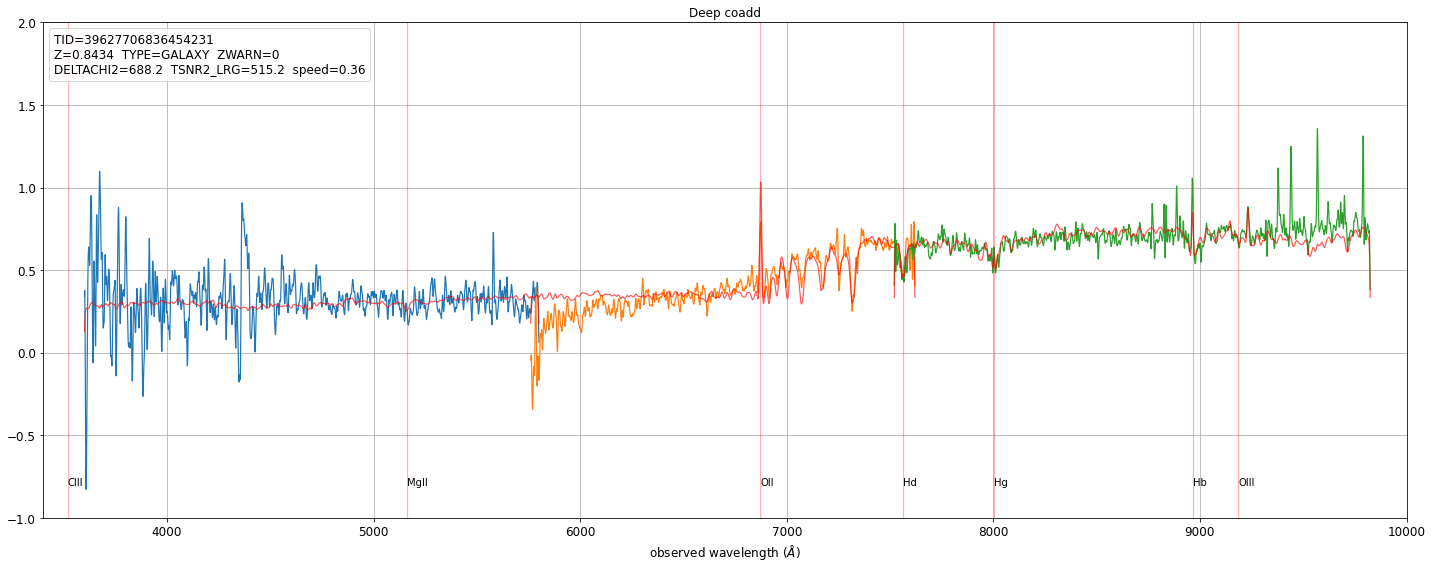


/global/cfs/cdirs/desi/spectro/redux/everest/tiles/1x_depth/80605/2/coadd-6-80605-1xsubset2.fits
INFO:spectra.py:282:read_spectra: iotime 0.446 sec to read coadd-6-80605-1xsubset2.fits at 2021-11-11T09:53:04.380351
DEBUG: Read templates from /global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/code/redrock-templates/master
DEBUG: Using default redshift range -0.0050-1.6997 for rrtemplate-galaxy.fits
DEBUG: Using default redshift range 0.0500-5.9934 for rrtemplate-qso.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-A.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-B.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-CV.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-F.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-G.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-K.fits
DEBUG: Using default redshift range -0.002

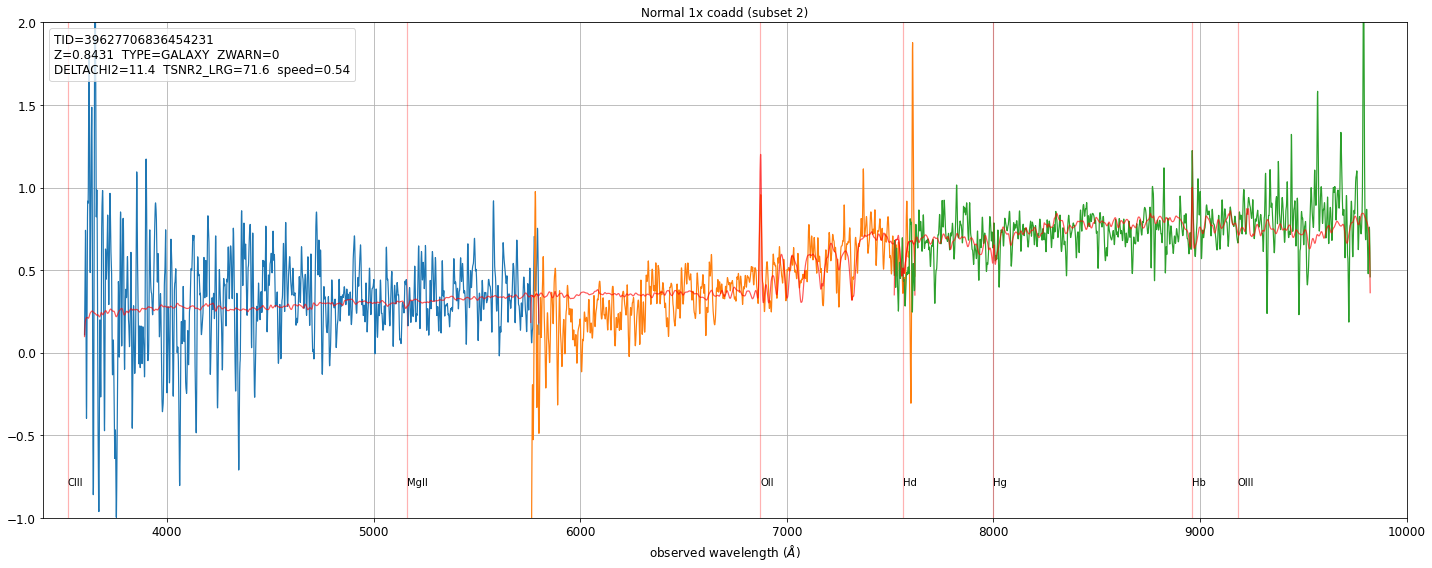


/global/cfs/cdirs/desi/users/rongpu/everest/low_speed/80605/2/coadd-6-80605-lowspeedsubset2.fits
INFO:spectra.py:282:read_spectra: iotime 0.563 sec to read coadd-6-80605-lowspeedsubset2.fits at 2021-11-11T09:53:05.914935
DEBUG: Read templates from /global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/code/redrock-templates/master
DEBUG: Using default redshift range -0.0050-1.6997 for rrtemplate-galaxy.fits
DEBUG: Using default redshift range 0.0500-5.9934 for rrtemplate-qso.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-A.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-B.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-CV.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-F.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-G.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-K.fits
DEBUG: Using default redshift range 

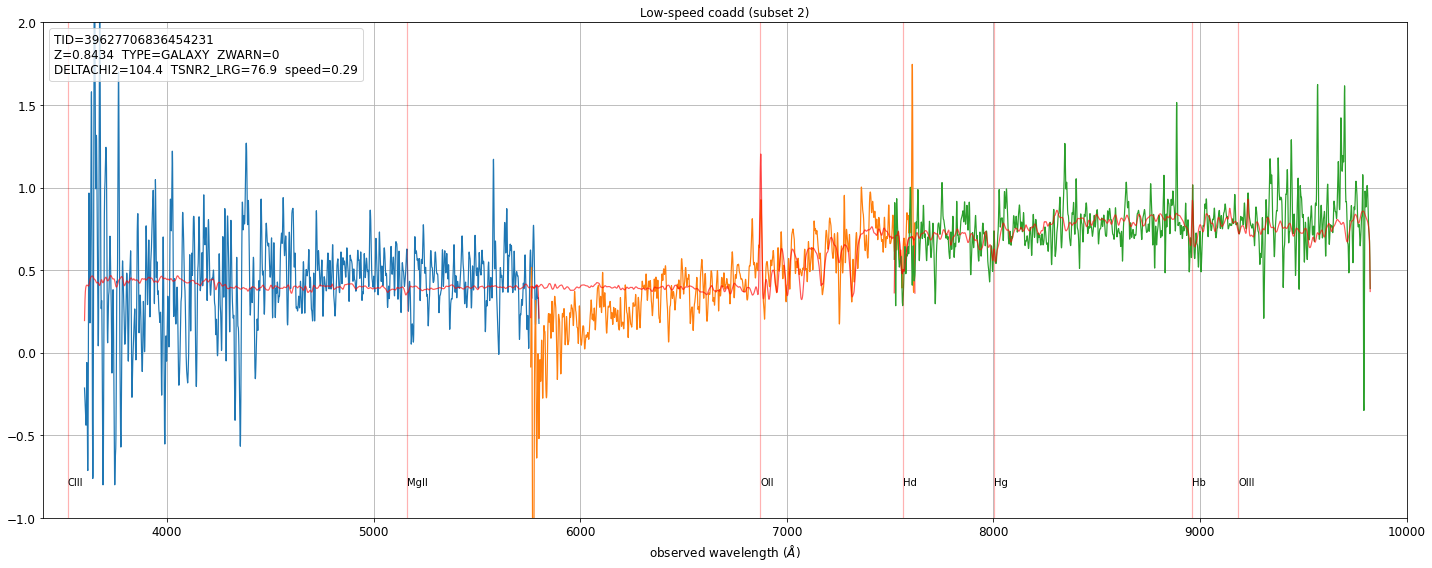

In [17]:
# idx = np.random.choice(len(cat), size=len(cat), replace=False)
idx = np.where(cat['TARGETID']==39627706836454231)[0]

for index in idx:

    targetid, tileid, petal, subset, z_deep = cat['TARGETID'][index], cat['TILEID'][index], cat['PETAL_LOC'][index], cat['subset'][index], cat['Z_deep'][index]
    nominal_mask = nominal['TARGETID']==targetid
    nominal_mask &= np.abs((nominal['EFFTIME_LRG']-cat['EFFTIME_LRG'][index])/cat['EFFTIME_LRG'][index])<0.1
    # if np.sum(nominal_mask)==0:
    #     continue

    print(targetid, np.sum(nominal_mask))

    # Deep coadds
    deep_index = np.where(deep['TARGETID']==targetid)[0][0]
    label = 'TID={}\nZ={:.4f}  TYPE={}  ZWARN={}\nDELTACHI2={:.1f}  TSNR2_LRG={:.1f}  speed={:.2f}'.format(deep['TARGETID'][deep_index], deep['Z'][deep_index], deep['SPECTYPE'][deep_index], deep['ZWARN'][deep_index], deep['DELTACHI2'][deep_index], deep['TSNR2_LRG'][deep_index], deep['speed'][deep_index])
    deep_fn = os.path.join('/global/cfs/cdirs/desi/spectro/redux/everest/tiles/cumulative', 
                       '{}/*/coadd-{}-{}-*.fits'.format(tileid, petal, tileid))
    deep_fn = glob.glob(deep_fn)[0]
    print(deep_fn)
    plot_spectrum(deep_fn, targetid, use_targetid=True, label=label, show=True, show_restframe=False, title='Deep coadd')
    print()

    # 1x coadds
    nom_idx = np.where(nominal_mask)[0]
    for nom_index in nom_idx:
        nom_subset = nominal['subset'][nom_index]        
        nominal_fn = os.path.join('/global/cfs/cdirs/desi/spectro/redux/everest/tiles/1x_depth', 
                           '{}/{}/coadd-{}-{}-1xsubset{}.fits'.format(tileid, nom_subset, petal, tileid, nom_subset))
        print(nominal_fn)
        label = 'TID={}\nZ={:.4f}  TYPE={}  ZWARN={}\nDELTACHI2={:.1f}  TSNR2_LRG={:.1f}  speed={:.2f}'.format(nominal['TARGETID'][nom_index], nominal['Z'][nom_index], nominal['SPECTYPE'][nom_index], nominal['ZWARN'][nom_index], nominal['DELTACHI2'][nom_index], nominal['TSNR2_LRG'][nom_index], nominal['speed'][nom_index])
        plot_spectrum(nominal_fn, targetid, use_targetid=True, label=label, show=True, show_restframe=False, title='Normal 1x coadd (subset {})'.format(nom_subset))
        print()

    # Low-speed coadds
    lowspeed_fn = os.path.join('/global/cfs/cdirs/desi/users/rongpu/everest/low_speed', 
                               '{}/{}/coadd-{}-{}-lowspeedsubset{}.fits'.format(tileid, subset, petal, tileid, subset))
    print(lowspeed_fn)
    label = 'TID={}\nZ={:.4f}  TYPE={}  ZWARN={}\nDELTACHI2={:.1f}  TSNR2_LRG={:.1f}  speed={:.2f}'.format(cat['TARGETID'][index], cat['Z'][index], cat['SPECTYPE'][index], cat['ZWARN'][index], cat['DELTACHI2'][index], cat['TSNR2_LRG'][index], cat['speed'][index])
    plot_spectrum(lowspeed_fn, targetid, use_targetid=True, label=label, show=True, show_restframe=False, title='Low-speed coadd (subset {})'.format(subset))
    print()